## Keras denoising autoencoder

Modified version from keras example: https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

Using TensorFlow backend.


In [38]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import preprocess

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

In [4]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
gt = gt[2:-1]

# shift ids to start at 0
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 10

In [7]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

In [8]:
# use all templates
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [9]:
templates, _ = preprocess(CONFIG, gt,
                          path_to_standarized,
                          chosen_templates,
                          crop_spatially=False)

100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


In [10]:
templates.shape

(41, 61, 49)

In [11]:
min_amplitude = 5
max_amplitude = 80
n_clean_per_template = 30

# this creates clean spikes where the main channel is always the first one
x_clean = util.make_clean(templates, min_amplitude, max_amplitude,
                          n_clean_per_template)

In [12]:
n_spikes, waveform_length, n_neighbors = x_clean.shape

In [13]:
print(x_clean.shape)

(1230, 61, 49)


In [14]:
selected = np.random.randint(n_spikes, size=10)

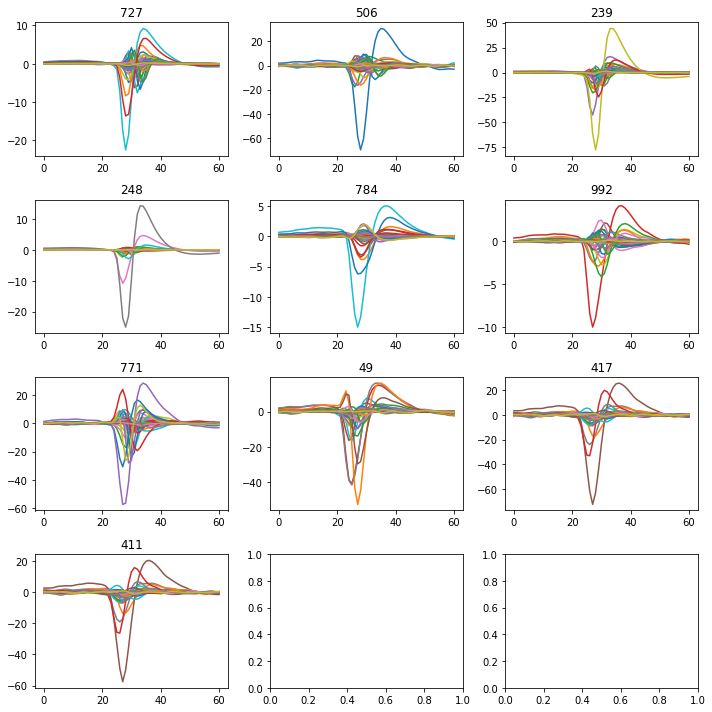

In [15]:
plot.grid_from_array(x_clean, axis=0, elements=selected,
                     figsize=(10, 10))

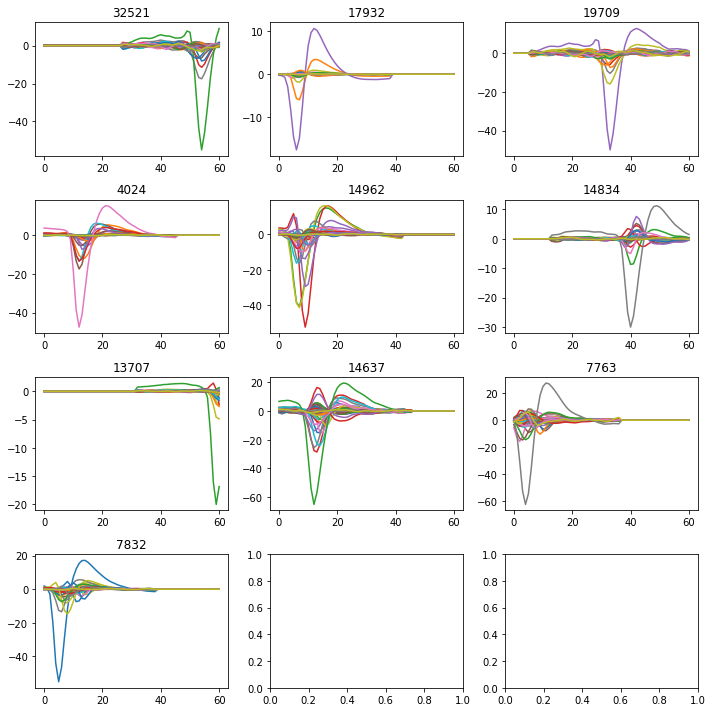

In [16]:
# make misaligned
n_misaligned_per_clean = 30
x_misaligned = util.make_temporally_misaligned(x_clean,
                                               n_per_spike=n_misaligned_per_clean,
                                               multi=True)
plot.grid_from_array(x_misaligned, axis=0, elements=10, figsize=(10, 10))

In [17]:
x_misaligned.shape

(36900, 61, 49)

In [18]:
# TODO: add some zero signal to create examples when there is pure noise
x_pure_noise = np.zeros((int(x_misaligned.shape[0] * 0.10), 61, 49))
x_misaligned = np.concatenate((x_misaligned, x_pure_noise), axis=0)

In [19]:
x_misaligned.shape

(40590, 61, 49)

## Generating train and test sets

In [20]:
X_ALL = np.copy(x_misaligned)

In [21]:
neigh_channels = CONFIG.neigh_channels
neigh_channels = np.ones((49, 49), dtype=bool)

# determine noise covariance structure
spatial_SIG, temporal_SIG = noise_cov(path_to_standarized,
                                      neigh_channels,
                                      CONFIG.geom,
                                      templates.shape[1])

print(spatial_SIG.shape, temporal_SIG.shape)

(49, 49) (61, 61)


In [22]:
n = X_ALL.shape[0]
prop = 0.7

train_idx = np.random.choice(n, size=int(n * prop), replace=False)

test_idx = np.ones(n, dtype=bool)
test_idx[~train_idx] = False

In [23]:
# split in train test
np.random.shuffle(X_ALL)

x_train = X_ALL[train_idx]
x_test = X_ALL[test_idx]

# create noisy versions of each
x_train_noisy = util.add_noise(x_train, spatial_SIG, temporal_SIG)
x_test_noisy = util.add_noise(x_test, spatial_SIG, temporal_SIG)

In [24]:
selected = np.random.randint(x_train.shape[0], size=10)

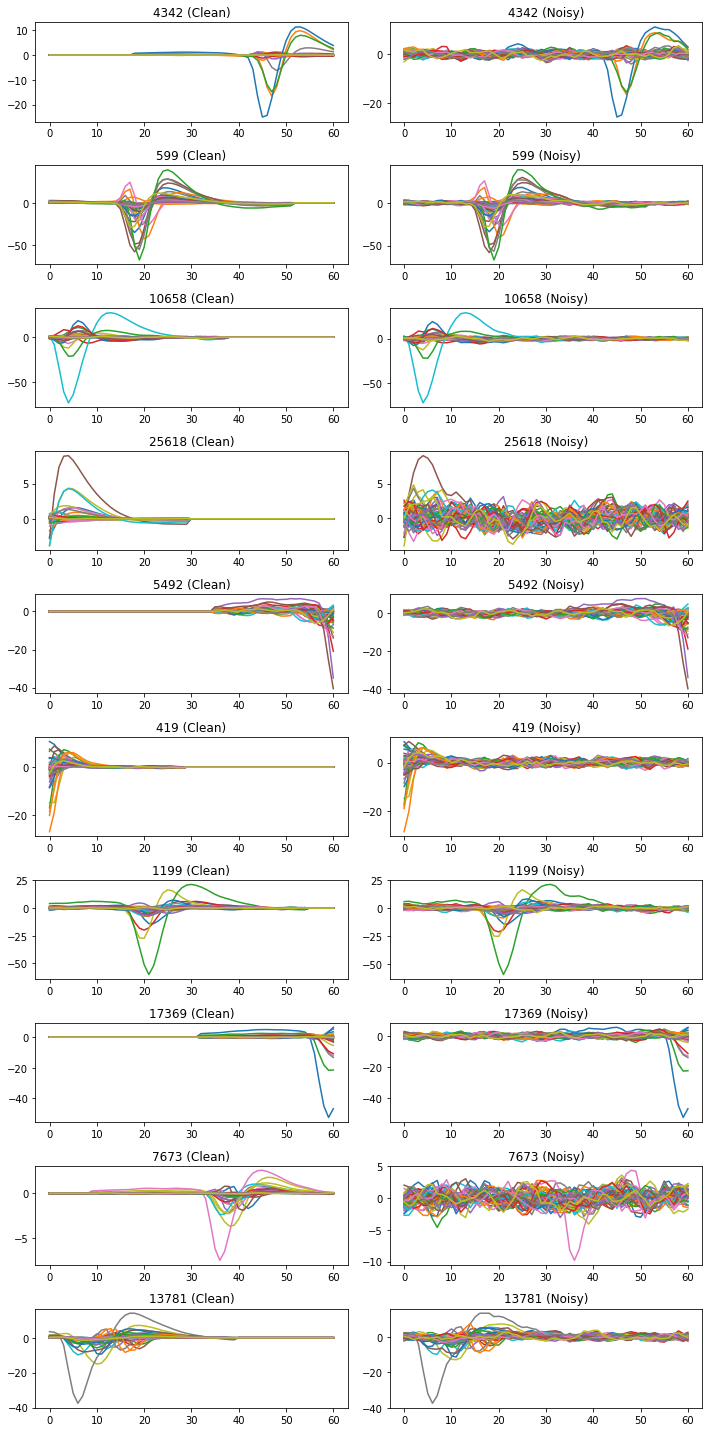

In [36]:
plot.grid_from_array([np.squeeze(x_train), np.squeeze(x_train_noisy)],
                     axis=0,
                     elements=selected,
                     group_names=('Clean', 'Noisy'),
                     figsize=(10, 20))

In [27]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

x_train_noisy = x_train_noisy[:, :, :, np.newaxis]
x_test_noisy = x_test_noisy[:, :, :, np.newaxis]

In [28]:
print(x_train_noisy.shape, x_train.shape,
      x_test_noisy.shape, x_test.shape)

(28413, 61, 49, 1) (28413, 61, 49, 1) (12177, 61, 49, 1) (12177, 61, 49, 1)


In [31]:
# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 128
kernel_size = 3
latent_dim = 32

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)


outputs = Activation('linear', name='decoder_output')(x)

# outputs = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 49, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 49, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 49, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 191296)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                6121504   
Total params: 6,140,320
Trainable params: 6,140,320
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


## Training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2)]

In [32]:
# Train the autoencoder
epochs = 35

autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=40,
                callbacks=callbacks,
                batch_size=batch_size)

Train on 28413 samples, validate on 12177 samples
Epoch 1/40
28413/28413 [==============================] - 44s 2ms/step - loss: 3.8276 - val_loss: 2.7757
Epoch 2/40
28413/28413 [==============================] - 43s 2ms/step - loss: 2.4365 - val_loss: 2.1243
Epoch 3/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.9792 - val_loss: 1.8641
Epoch 4/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.7328 - val_loss: 1.6891
Epoch 5/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.5675 - val_loss: 1.5699
Epoch 6/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.4308 - val_loss: 1.4785
Epoch 7/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.3157 - val_loss: 1.3969
Epoch 8/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.2072 - val_loss: 1.3299
Epoch 9/40
28413/28413 [==============================] - 43s 2ms/step - loss: 1.1215 - val_loss: 1.2878
Epoch

In [39]:
# save model
name = reproducibility.make_filename('h5')
autoencoder.save(name)
print('Saved {}'.format(name))

Saved 25-Jul-2018@23-49-01.h5


## Denoising on patches


In [40]:
def predict(model, x):
    x = x[:, :, :, np.newaxis]
    predictions = model.predict(x)
    return np.squeeze(predictions)

In [41]:
x_test_decoded = predict(autoencoder, np.squeeze(x_test_noisy))

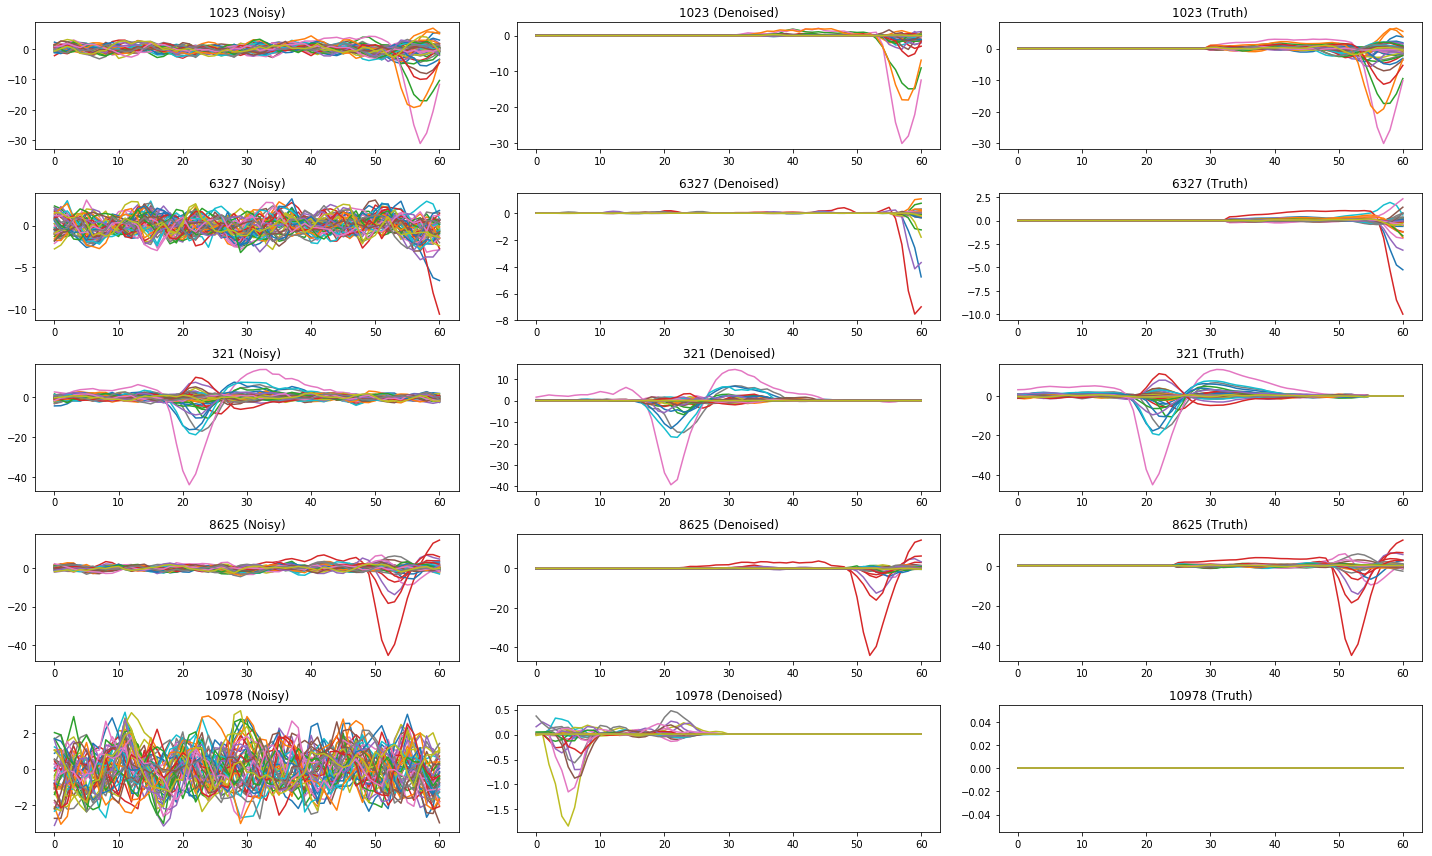

In [59]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_decoded,
                      np.squeeze(x_test)],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Truth'),
                     elements=5,
                     auto_figsize=4,
                     sharey=False)

In [43]:
from yass.augment import util
import pandas as pd

def to_data_frame(array):
    wfs = [a for a in array]
    df = pd.DataFrame(data={'waveforms': wfs,
                            'amplitudes': util.amplitudes(wfs)})
    return df

df = to_data_frame(x_test_noisy_)

NameError: name 'x_test_noisy_' is not defined

In [ ]:
idx = df[(3 < df.amplitudes) & (df.amplitudes < 4)].index[:3]

plot.grid_from_array([x_test_noisy_, x_test_, x_decoded_],
                     axis=0, elements=idx,
                     figsize=(15, 15))

In [ ]:
idx = df[(10 < df.amplitudes) & (df.amplitudes < 20)].index[:3]

plot.grid_from_array([x_test_noisy_, x_test_, x_decoded_],
                     axis=0, elements=idx,
                     figsize=(15, 15))

## Denoising recordings

In [44]:
exp = RecordingExplorer(path_to_standarized)

In [45]:
patch_size = 61
n_patches = 5

In [46]:
idxs = [(n * patch_size, (n + 1) * patch_size) for n in range(n_patches)]

In [47]:
# TODO: performance improvement, read a lot of patches and send them to .predict
processed = np.zeros((patch_size * n_patches, 49))

for from_, to_ in idxs:
    patch = exp.reader[from_:to_, :][np.newaxis, :, :, np.newaxis]
    processed[from_:to_, :] = np.squeeze(autoencoder.predict(patch))

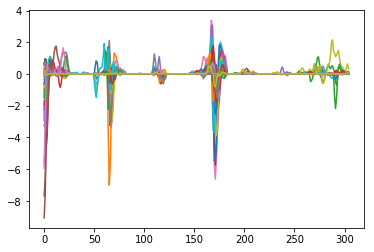

In [48]:
_ = plt.plot(processed)

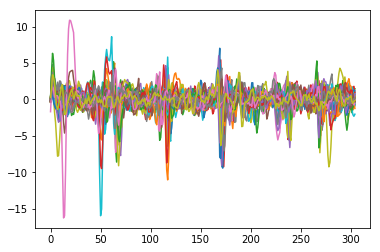

In [49]:
_ = plt.plot(exp.reader[:to_])